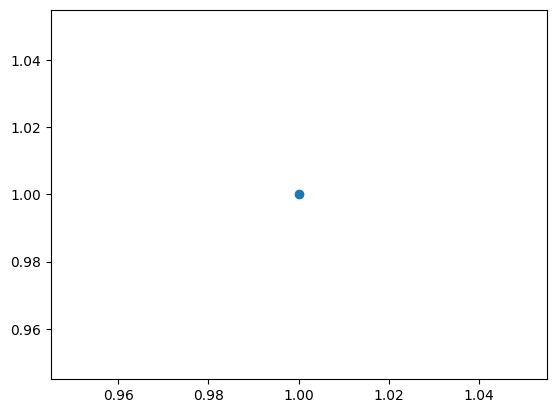

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.scatter(1,1)

In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from PIL import Image
import random

In [3]:
main_dir = 'Small_dataset'
train_dir = 'Training/'
class_names = os.listdir(os.path.join(main_dir, train_dir))

In [7]:
classes = len([x for x in os.walk(os.path.join(main_dir, train_dir))])
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(8)
        
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 100)
        self.fc6 = nn.Linear(100, classes)
        
    def forward(self, X):
        
        X = self.conv1(X)
        X = self.conv1_bn(X)
        X = F.relu(X)
        X = self.pool(X)
              
        X = self.conv2(X)
        X = self.conv2_bn(X)
        X = F.relu(X)
        X = self.pool(X)
        
        X = X.view(-1, 1024)

        X = self.fc1(X)
        X = F.relu(X)
        Y = X
        
        X = self.fc2(X)
        X = F.relu(X)
        X = X + Y
        
        X = self.fc3(X)
        X = F.relu(X)
        Y = X
        
        X = self.fc4(X)
        X = F.relu(X)
        X = X + Y
        
        X = self.fc5(X)
        X = F.relu(X)
        
        X = self.fc6(X)
        X = F.sigmoid(X)
        return X 
model = torch.load('Models/FRUITS_32_5', weights_only= 0,map_location=torch.device('cpu'))

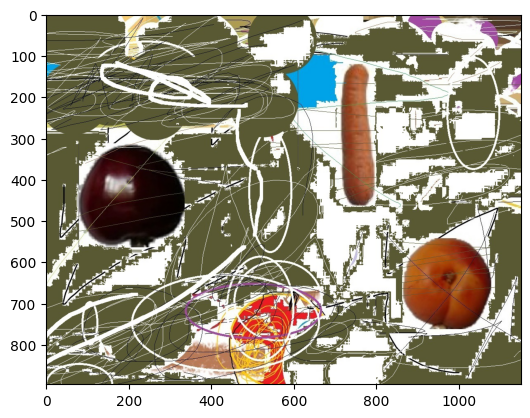

In [8]:
image_path = "Find_here.jpg"
image = Image.open(image_path)
plt.imshow(image)
plt.show()

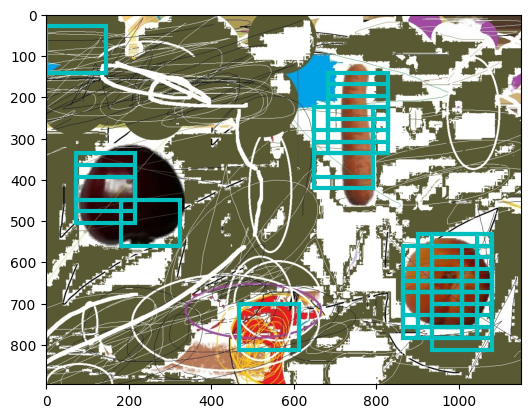

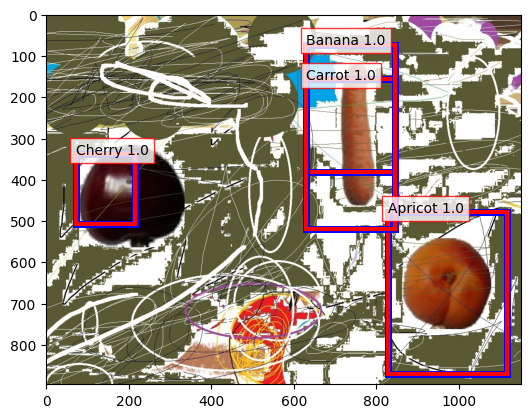

In [9]:
fig, ax = plt.subplots()
ax.imshow(image)

N = 8
im_width, im_height = image.size
prim_width, prim_height = np.ceil(im_width/N), np.ceil(im_height/N)
prim_width, prim_height = prim_width - prim_width%2, prim_height - prim_height%2

SELECTED = []

for i in range(N*4-3):
    i/= 4
    for j in range(N*4-3):
        j/= 4
        
        part = image.crop((prim_width * i, prim_height * j, prim_width * (i+1), prim_height * (j+1)))
        part = part.resize((32,32))

        transform = transforms.Compose([transforms.PILToTensor()])
        output = model((transform(part)/255).unsqueeze(0))
        
        P = torch.max(output)   
        label = class_names[list(map(float, output[0])).index(P)]
        
        if label != 'Trash' and P >= 0.9:
           
            rect = patches.Rectangle((prim_width * i, prim_height * j), prim_width, prim_height, linewidth=3, edgecolor='c', facecolor='none')
            ax.add_patch(rect)
            SELECTED.append((label,float(P) ,(prim_width * i + prim_width/2, prim_height * j + prim_width/2)))
 
random.shuffle(SELECTED)
matches = []
while len(SELECTED):
    A = SELECTED[0]
    bros = [A]
    same = [0]
    for j in range(1,len(SELECTED)):        
        if SELECTED[j][0] == A[0] and ((SELECTED[j][2][1]-A[2][1])**2 + (SELECTED[j][2][0]-A[2][0])**2)**0.5 <= 250:
            same.append(j)
            bros.append(SELECTED[j])
    
    for n in same[::-1]:
        SELECTED.pop(n)
    matches.append(bros)
    
fig, ax = plt.subplots()
ax.imshow(image)
for i in matches:
    if len(i) > 1:
        maxy = -1
        miny = 99999
        maxx = -1
        minx = 99999
        for j in i:       
            maxx = max(maxx, j[2][0])
            maxy = max(maxy, j[2][1])
            minx = min(minx, j[2][0])
            miny = min(miny, j[2][1])
            
        rect = patches.Rectangle([minx-(prim_width + maxx - minx)/2, miny-(prim_height+ maxy - miny)/2], prim_width + 2*(maxx - minx), prim_height+ 2*(maxy - miny), linewidth=5, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.text(minx-(prim_width + maxx - minx)/2, miny-(prim_height+ maxy - miny)/2,f'{i[0][0][:-2]} {P}',).set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='red'))
        rect = patches.Rectangle([minx-(prim_width + maxx - minx)/2, miny-(prim_height+ maxy - miny)/2], prim_width + 2*(maxx - minx), prim_height+ 2*(maxy - miny), linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)